In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!mkdir -p ~/ .kaggle

In [4]:
!cp -r /content/drive/MyDrive/kaggle.json ~/ .kaggle/


In [5]:
!chmod 600 ~/ .kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d msambare/fer2013

In [ ]:
!unzip /content/fer2013.zip

In [26]:
import os
import numpy as np
import pandas as pd
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import scipy
import matplotlib.pyplot as plt

In [32]:
seed=24
batch_size=  32

img_data_gen_args = dict(
                      rescale = 1/255.,
                         #rotation_range=90,
                      width_shift_range=0.2,
                      height_shift_range=0.2,
                      #shear_range=0.5,
                      #zoom_range=0.3,
                      #horizontal_flip=True,
                      #vertical_flip=True,
                      fill_mode='nearest'
                         )

image_data_generator = ImageDataGenerator(**img_data_gen_args)


In [33]:
train_image_generator = image_data_generator.flow_from_directory("/content/train",
                                                           seed=seed,
                                                           target_size=(224, 224), # for the target size (transfer learning)
                                                           batch_size=batch_size,
                                                           interpolation = "lanczos",
                                                           color_mode = "rgb",
                                                           class_mode="categorical")

Found 28709 images belonging to 7 classes.


In [34]:
test_image_generator = image_data_generator.flow_from_directory("/content/test",
                                                           seed=seed,
                                                           target_size=(224, 224), # for the target size (transfer learning)
                                                           batch_size=batch_size,
                                                           interpolation = "lanczos",
                                                           color_mode = "rgb",
                                                           class_mode="categorical")

Found 7178 images belonging to 7 classes.


In [35]:
train_image_generator.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

(224, 224, 3)


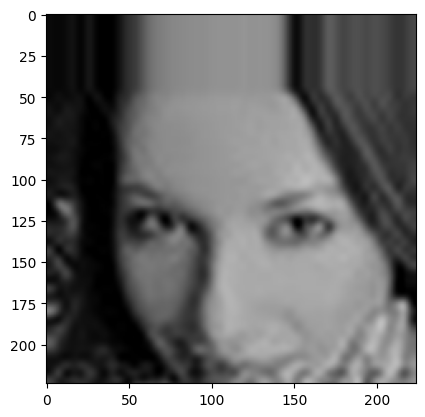

4


In [36]:
x,y = train_image_generator.next()
print(x[0].shape)
plt.imshow(x[0])
plt.show()
print(y[0].argmax())

In [13]:
y.shape

(32, 7)

In [14]:
x.shape

(32, 224, 224, 3)

# Transfer Learning for classification

In [37]:
import tensorflow as tf
from tensorflow.keras import layers

In [38]:
model = tf.keras.applications.MobileNetV2()
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [39]:
base_input = model.layers[0].input

In [40]:
base_output = model.layers[-2].output

In [41]:
base_output

<KerasTensor: shape=(None, 1280) dtype=float32 (created by layer 'global_average_pooling2d_1')>

In [42]:
Emotion_output = layers.Dense(128, activation = 'relu')(base_output)
Emotion_output = layers.Dense(64, activation = 'relu')(Emotion_output)
Emotion_output = layers.Dense(7, activation = "softmax")(Emotion_output)

In [43]:
final_model = tf.keras.Model(inputs = base_input, outputs = Emotion_output)
final_model.compile(loss = "categorical_crossentropy", optimizer="adam", metrics = ["accuracy"])

In [44]:
final_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

In [45]:
## let's introduce the Modelcheckpoint to save the best model for each epoch to avoid errors
checkpointer = tf.keras.callbacks.ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
## let's implement the EarlyStopping!
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=4, monitor='val_loss'), checkpointer ]

In [46]:
history = final_model.fit(train_image_generator,validation_data=test_image_generator,
                    epochs=100, verbose= 1, callbacks=callbacks)


Epoch 1/100
898/898 [==============================] - ETA: 0s - loss: 1.2989 - accuracy: 0.5109
Epoch 1: val_loss improved from inf to 5.60992, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


898/898 [==============================] - 429s 454ms/step - loss: 1.2989 - accuracy: 0.5109 - val_loss: 5.6099 - val_accuracy: 0.1833
Epoch 2/100
898/898 [==============================] - ETA: 0s - loss: 1.1280 - accuracy: 0.5819
Epoch 2: val_loss improved from 5.60992 to 3.82457, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


898/898 [==============================] - 408s 454ms/step - loss: 1.1280 - accuracy: 0.5819 - val_loss: 3.8246 - val_accuracy: 0.2505
Epoch 3/100
898/898 [==============================] - ETA: 0s - loss: 1.0609 - accuracy: 0.6054
Epoch 3: val_loss improved from 3.82457 to 2.38142, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


898/898 [==============================] - 407s 453ms/step - loss: 1.0609 - accuracy: 0.6054 - val_loss: 2.3814 - val_accuracy: 0.4250
Epoch 4/100
898/898 [==============================] - ETA: 0s - loss: 1.0064 - accuracy: 0.6226
Epoch 4: val_loss did not improve from 2.38142
898/898 [==============================] - 408s 454ms/step - loss: 1.0064 - accuracy: 0.6226 - val_loss: 2.4072 - val_accuracy: 0.4195
Epoch 5/100
898/898 [==============================] - ETA: 0s - loss: 0.9732 - accuracy: 0.6393
Epoch 5: val_loss improved from 2.38142 to 2.07590, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


898/898 [==============================] - 408s 454ms/step - loss: 0.9732 - accuracy: 0.6393 - val_loss: 2.0759 - val_accuracy: 0.3777
Epoch 6/100
898/898 [==============================] - ETA: 0s - loss: 0.9382 - accuracy: 0.6504
Epoch 6: val_loss improved from 2.07590 to 1.44533, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


898/898 [==============================] - 406s 453ms/step - loss: 0.9382 - accuracy: 0.6504 - val_loss: 1.4453 - val_accuracy: 0.5418
Epoch 7/100
898/898 [==============================] - ETA: 0s - loss: 0.9115 - accuracy: 0.6601
Epoch 7: val_loss did not improve from 1.44533
898/898 [==============================] - 409s 456ms/step - loss: 0.9115 - accuracy: 0.6601 - val_loss: 1.5743 - val_accuracy: 0.4744
Epoch 8/100
898/898 [==============================] - ETA: 0s - loss: 0.8781 - accuracy: 0.6749
Epoch 8: val_loss did not improve from 1.44533
898/898 [==============================] - 408s 455ms/step - loss: 0.8781 - accuracy: 0.6749 - val_loss: 1.7556 - val_accuracy: 0.5180
Epoch 9/100
898/898 [==============================] - ETA: 0s - loss: 0.8585 - accuracy: 0.6830
Epoch 9: val_loss did not improve from 1.44533
898/898 [==============================] - 405s 451ms/step - loss: 0.8585 - accuracy: 0.6830 - val_loss: 1.8326 - val_accuracy: 0.5458
Epoch 10/100
898/898 [======

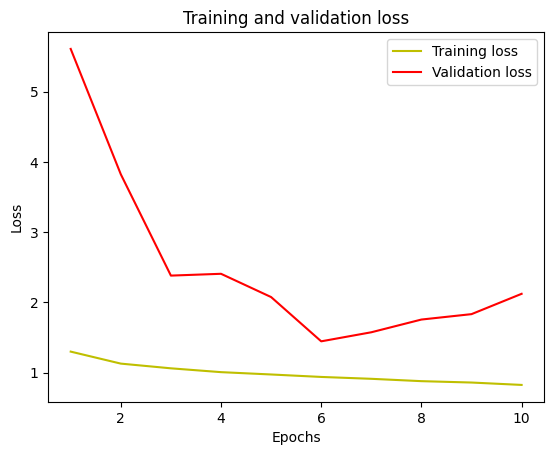

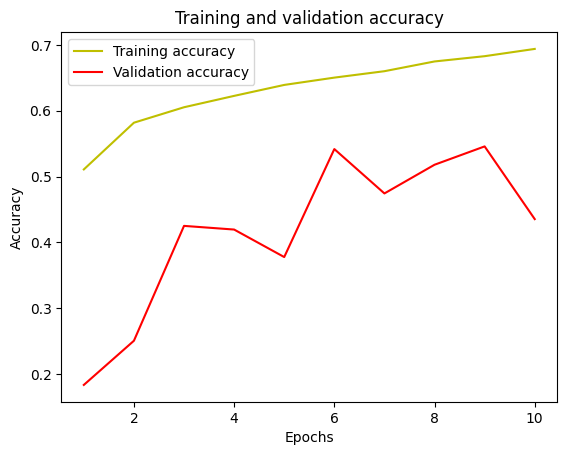

In [48]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
#acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()